In [1]:
import sys
import pylab as plb
import numpy as np
import mountaincar

In [122]:
class DummyAgent():
    """A not so good agent for the mountain-car task.
    """

    def __init__(self, mountain_car = None, x_linspace = (-150, 30, 20),
                v_linspace = (-15, 15, 20), w = None, tau = 1, gamma = 0.95,
                 eta = 0.0001, lambda_ = 0.95):
        ''' Initialize the object '''
        
        # saving the environment object
        if mountain_car is None:
            self.mountain_car = mountaincar.MountainCar()
        else:
            self.mountain_car = mountain_car
        
        # range for x neurons grid
        self.x_values = np.linspace(*x_linspace)

        # range for v neurons grid
        self.v_values = np.linspace(*v_linspace)

        # steps x and v
        self.delta_x = self.x_values[1] - self.x_values[0]
        self.delta_v = self.v_values[1] - self.v_values[0]

        # sigmas x and v
        self.sigma_x = np.array([self.delta_x] * len(self.x_values))
        self.sigma_v = np.array([self.delta_v] * len(self.v_values))

        # number of actions
        self.n_actions = 3

        # number of neurons
        self.n_neurons = len(self.x_values) * len(self.v_values)

        # weight matrix
        if w is None:
            #self.w = np.random.randn(self.n_actions, self.n_neurons)
            self.w = np.zeros((self.n_actions, self.n_neurons))
        else:
            self.w = w

        # sampling softmax temperature
        self.tau = tau
        
        # reward discount factor
        self.gamma = gamma
        
        # learning rate
        self.eta = eta
        
        # eligibility trace parameter
        self.lambda_ = lambda_
            
    def r(self, x, v):
        ''' get neuron activations for s = (x, v) '''
        # x in rows, v in columns
        part_x = np.reshape(np.divide((self.x_values - x) ** 2, self.sigma_x ** 2), (-1, 1))
        part_v = np.reshape(np.divide((self.v_values - v) ** 2, self.sigma_v ** 2), (1, -1))
        return np.exp(-(part_x + part_v))

    def get_Q(self, x, v):
        ''' Get Q-function at given s = (x, v) with weights w '''
        
        return np.reshape(self.w @ np.reshape(self.r(x, v), (-1, 1)), (-1,))

    def get_action_probas(self, Q):
        ''' get action probabilities as a vector '''

        vector = np.exp(Q / self.tau)
        ret = vector / np.sum(vector)
        if not(0.9999 <= sum(ret) <= 1.00001):
            print("Probability does not sum up! They're: {}, with sum {}".format(ret,sum(ret)))
        return vector / np.sum(vector)

    def get_action_index(self, x, v):
        ''' Sample action for s = (x, v) and weights w with parameter tau '''

        Q = self.get_Q(x, v)
        action_probas = self.get_action_probas(Q)
        return np.random.choice(range(self.n_actions), p = action_probas)

    def update_w(self, x, v, a_index, delta):
        ''' Perform gradient descent on Q(s, a) by delta given s and a'''
        
        dQ_dwa = np.reshape(self.r(x, v), -1)
        self.w[a_index, :] += delta * dQ_dwa

    def visualize_trial(self, n_steps = 200):
        """Do a trial without learning, with display.

        Parameters
        ----------
        n_steps -- number of steps to simulate for
        """
        
        # prepare for the visualization
        plb.ion()
        mv = mountaincar.MountainCarViewer(self.mountain_car)
        mv.create_figure(n_steps, n_steps)
        plb.draw()
        plb.pause(1e-3)
            
        # make sure the mountain-car is reset
        self.mountain_car.reset()
        
        for n in (range(n_steps)):
            print('\rt =', self.mountain_car.t)
            sys.stdout.flush()
            
            # get current state
            s = (self.mountain_car.x, self.mountain_car.x_d)

            # selection current action based on softmax
            action_index = self.get_action_index(*s)
            
            # perform the action
            self.mountain_car.apply_force(action_index - 1)
            
            # simulate the timestep
            self.mountain_car.simulate_timesteps(100, 0.01)

            # update the visualization
            mv.update_figure()
            plb.draw()
            plb.pause(1e-3)
            
            # check for rewards
            if self.mountain_car.R > 0.0:
                print("\rreward obtained at t = ", self.mountain_car.t)
                break

    def learn(self, max_steps = 1500):
        """Do a trial without learning, with display.

        Parameters
        ----------
        n_steps -- number of steps to simulate for
        """
            
        # make sure the mountain-car is reset
        self.mountain_car.reset()

        # saved previous state
        old_s = None
        old_a = None
        
        # all states and actions array
        all_s_a = []
        
        # is finished
        finished = False
        
        time = 0
        
        for n in (range(max_steps)):
            # get current state
            s = (self.mountain_car.x, self.mountain_car.x_d)
            #print("state is {}".format(s))
            
            #print('\rt =', s, self.mountain_car.t, self.get_action_index(*s))
            sys.stdout.flush()

            # selection current action based on softmax
            action_index = self.get_action_index(*s)
            #print("action_index is {}".format(action_index))

            # save all past s, a
            all_s_a.append((s, action_index))
            #print("all_s_a is {}".format(all_s_a))
            
            # perform the action
            self.mountain_car.apply_force(action_index - 1)
            
            # simulate the timestep
            self.mountain_car.simulate_timesteps(100, 0.01)
            
            # check for rewards (runs at the end once)
            if self.mountain_car.R > 0.0:
                # print the obtained reward
                #print(len(all_s_a))
                time += len(all_s_a) #Update escape latency time
                #print("\rreward obtained at t = ", self.mountain_car.t)
                
                # compute vector [xi ^ (T-1), ..., 1] where xi = gamma * lambda
                eligibility_trace = np.flip(np.array([self.gamma * self.lambda_]) **
                                            np.arange(len(all_s_a)), axis = 0)
                
                # compute the update for the Q function
                # update = eta * delta (from lectures)
                
                # old Q
                Q = self.get_Q(*old_s)[old_a]
                
                # new Q
                Q1 = np.max(self.get_Q(*s))
                
                # eta * (R + gamma * Qnew - Qold)
                update = self.eta * (self.mountain_car.R + self.gamma * Q1 - Q)
                
                # loop over history
                i = 0
                
                for s0, a0 in all_s_a:
                    #print("states and actions are {},{}".format(s0, a0))
                    #print("elig. trace is {}".format(eligibility_trace[i]))
                    #print("i is {}".format(i))
                    # updating weights with SARSA(\lambda) algortihm
                    self.update_w(s0[0], s0[1], a0, update * eligibility_trace[i])
                    i += 1
                    
                # no steps after the reward
                finished = True
                break
                
            # saving old state
            old_s = s
            old_a = action_index
        #if not finished:
            #print('No reward :( ')
            
        return time, all_s_a
    
    def get_action_field(self,x_range,v_range):
        """Gets action vector field for each trial
            using all 180 values for x \in [-150,30] and
            30 values for \dot(x) \in [-15,15]"""
        
        states = np.zeros((len(x_range),len(v_range)),dtype=tuple)
        for i in range(len(x_range)):
            for j in range(len(v_range)):
                states[i,j] = (x_range[i],v_range[j])
        
                
        #action_fields =  np.zeros((len(x_range),len(v_range)))
        action_fields_right =  np.zeros((len(x_range),len(v_range)))
        action_fields_left =  np.zeros((len(x_range),len(v_range)))
        
        for i in range(states.shape[0]):
            for j in range(states.shape[1]):
                stuff = self.get_action_index(*states[i,j]) - 1
                if stuff == 1.:
                    action_fields_right[i,j] = stuff
                if stuff == -1.:
                    action_fields_left[i,j] = stuff
                #action_fields[i,j] = self.get_action_index(*states[i,j]) - 1
        
        return action_fields_right, action_fields_left
        #return action_fields
                

j in loop is 0
i in i==0 loop is 0


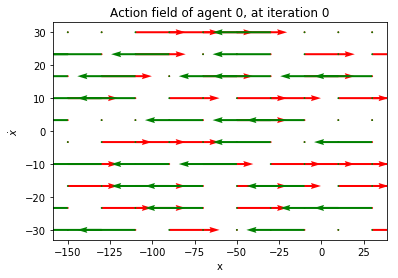

j in loop is 50
i in i==0 loop is 0


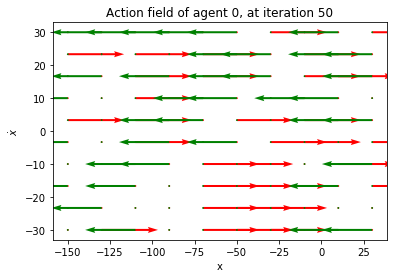

j in loop is 99
i in i==0 loop is 0


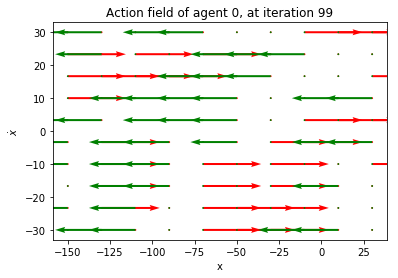

j in loop is 0
j in loop is 50
j in loop is 99
j in loop is 0
j in loop is 50
j in loop is 99
j in loop is 0
j in loop is 50
j in loop is 99
j in loop is 0
j in loop is 50
j in loop is 99
j in loop is 0
i in i==0 loop is 5


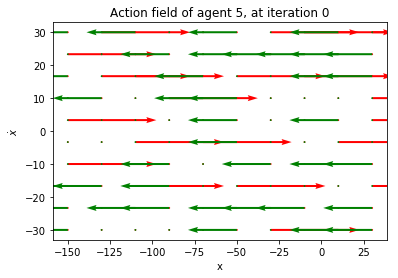

j in loop is 50
i in i==0 loop is 5


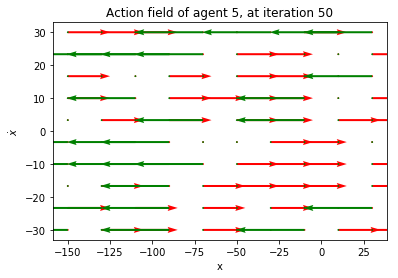

j in loop is 99
i in i==0 loop is 5


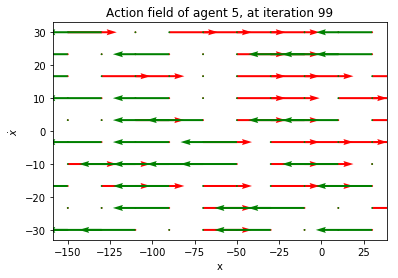

j in loop is 0
j in loop is 50
j in loop is 99
j in loop is 0
j in loop is 50
j in loop is 99
j in loop is 0
j in loop is 50
j in loop is 99
j in loop is 0
j in loop is 50
j in loop is 99
[ 339.8  306.4  204.2  302.7  621.4  378.6  649.7  539.1  577.   322.3
  505.4  552.   382.7  447.6  302.8  450.4  540.4  500.1  653.8  658.1
  525.6  417.   546.5  260.3  243.2  328.7  272.3  407.6  568.4  261.8
  175.5  404.4  211.1  162.5  444.7  380.8  276.3  320.9  279.1  362.
  453.5  232.5  273.6  525.6  253.7  378.9  320.7  226.1  291.5  418.9
  298.   222.8  293.9  320.2  141.   179.7  126.8  325.7  159.6  297.2
  376.5  377.   195.9  206.4  228.8  178.2  447.   394.2  191.5  269.8
  192.1  178.1  207.2  324.5  272.5  418.9  268.5  195.1  225.9  292.3
  235.1  165.9  183.8  179.9  240.4  199.4  213.7  157.2  211.3  136.4
  149.1  191.4  143.7  230.1  282.   188.8  324.1  223.1  316.7  136.5] (100,) agent averaged esacpe latency times


array([ 339.8,  306.4,  204.2,  302.7,  621.4,  378.6,  649.7,  539.1,
        577. ,  322.3,  505.4,  552. ,  382.7,  447.6,  302.8,  450.4,
        540.4,  500.1,  653.8,  658.1,  525.6,  417. ,  546.5,  260.3,
        243.2,  328.7,  272.3,  407.6,  568.4,  261.8,  175.5,  404.4,
        211.1,  162.5,  444.7,  380.8,  276.3,  320.9,  279.1,  362. ,
        453.5,  232.5,  273.6,  525.6,  253.7,  378.9,  320.7,  226.1,
        291.5,  418.9,  298. ,  222.8,  293.9,  320.2,  141. ,  179.7,
        126.8,  325.7,  159.6,  297.2,  376.5,  377. ,  195.9,  206.4,
        228.8,  178.2,  447. ,  394.2,  191.5,  269.8,  192.1,  178.1,
        207.2,  324.5,  272.5,  418.9,  268.5,  195.1,  225.9,  292.3,
        235.1,  165.9,  183.8,  179.9,  240.4,  199.4,  213.7,  157.2,
        211.3,  136.4,  149.1,  191.4,  143.7,  230.1,  282. ,  188.8,
        324.1,  223.1,  316.7,  136.5])

In [125]:
import matplotlib.pyplot as plt
av_times = {} #Dictionary for agent averaged times

def get_escape_rate(t=0.0001,et=0.0001,lam = 0.95, num_ags=10,its=100,plot_field=True):
    """Gets agent averaged escape times for given tau and lambda
        If plot_field = True, plots the action fields for three trials"""

    times = np.zeros((num_ags,its))
    #times_non_zero = np.zeros((num_ags))
    for i in range(num_ags):
        d = DummyAgent(tau = t,eta = et,lambda_ = lam)

        # learn for 100 iterations
        j_print = np.asarray([0,int(its/2),its - 1]) #Values to print Q field
        i_print = np.asarray([0,5,10])
        for j in range(its):
            time, hists = d.learn()
            times[i,j] = time
        
            x_range = np.linspace(-150,30,10)
            v_range = np.linspace(-30,30,10)
            if plot_field:
                if any(j==x for x in j_print):
                    print("j in loop is {}".format(j))
                    if any(i==x for x in i_print): #For the first agent
                        print("i in i==0 loop is {}".format(i))
                        fieldsr, fieldsl = d.get_action_field(x_range,v_range)
                        #fields = d.get_action_field(x_range,v_range)
                        y_comp = np.zeros((len(x_range),len(v_range)))
                        states_x, states_y = np.meshgrid(x_range,v_range)
                        plt.figure()
                        plt.title("Action field of agent {}, at iteration {}".format(i,j))
                        #Q = plt.quiver(states_x,states_y,fields,y_comp,units="dots",color='r')
                        Q1 = plt.quiver(states_x,states_y,fieldsr,y_comp,units="dots",color='r')
                        Q2 = plt.quiver(states_x,states_y,fieldsl,y_comp,units="dots",color='g')
                        plt.xlabel("x")
                        plt.ylabel(r'$\dot{x}$')
                        #qk = plt.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E', coordinates='figure')
                        plt.show()
        
        #print(times[i,:][np.nonzero(times[i,:])])
        #times_non_zero[i] = times[i,:][np.nonzero(times[i,:])]
    
    av_times = np.mean(times,axis=0)
    #av_times_nonzero = np.mean(times_non_zero,axis=0)
    print(av_times,av_times.shape,"agent averaged esacpe latency times")

    return av_times

get_escape_rate(plot_field=True)

# Escape time vs. trial for diff $\tau$ and $\lambda$

lambda is 0.9
tau is 0.0001
[ 232.7  365.6   28.8  417.4  437.6  439.2  261.9  489.1  605.7  686.6
  314.2  636.3  466.7  422.7  501.4  224.6  428.6  668.6  449.5  329.4
  448.6  484.3  257.3  415.8  458.9  370.   490.1  557.8  466.1  378.5
  368.1  466.8  543.   400.6  406.9  234.5  397.4  459.6  569.5  696.2
  398.7  248.   420.7  443.8  601.2  381.9  289.5  371.4  373.1  610.4
  286.6  665.9  404.   366.5  272.5  399.7  328.2  289.4  286.8  624.3
  309.   307.3  153.   401.4  399.2  333.1  166.9  193.   394.1  286.
  402.5  272.4  297.8  299.3  146.5  533.7  157.8  204.   351.9  386.2
  379.7  365.2  230.   196.9  214.8  308.4  403.7  380.5  195.1  375.3
  219.7  205.5  163.4  358.3  263.9  391.8  191.9  189.1  260.8  199.4] (100,) agent averaged esacpe latency times
tau is 1.0
[ 449.9  192.4  332.1  496.2  364.8  528.5  299.2  682.7  522.6  288.8
  349.1  579.1  446.8  362.5  149.5  606.5  453.8  396.3  421.7  256.3
  295.6  513.   405.6  369.5  314.1  795.3  220.   502.6  581.3  2

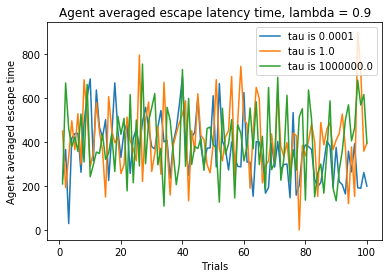

lambda is 0.95
tau is 0.0001
[ 564.2  528.   409.2  449.3  303.4  670.   566.1  339.2  295.2  507.
  568.7  324.4  251.3  306.9  407.9  586.9  365.2  197.4  425.8  409.8
  557.9  350.8  280.5  504.4  184.1  369.   302.9  315.8  428.6  397.7
  322.8  507.3  445.7  292.1  268.   420.9  408.6  342.5  389.9  236.2
  369.8  339.9  176.   433.3  278.4  216.   366.3  289.8  336.1  345.6
  271.1  128.5  186.5  148.8  419.2  380.1  270.4  293.1  301.7  270.8
  483.9  225.5  345.1  246.5  144.   268.6  369.   298.9  302.4  188.6
  178.7  300.4  220.2  314.7  137.   235.   275.7  259.2  417.   197.3
  308.5  295.5  326.6  131.8  226.9  243.1  324.1  222.3  125.6  178.4
  311.2  280.2  194.8  175.5  300.5  184.8  284.9  221.6  174.8  316.7] (100,) agent averaged esacpe latency times
tau is 1.0
[ 558.5  419.1  224.   252.3  383.6  340.2  162.7  373.3  234.3  454.6
  705.1  193.1  528.9  314.   513.6  622.6  355.3  365.   445.1  454.3
  330.   253.3  586.6  381.5  320.1  268.2  388.9  351.8  216.3  

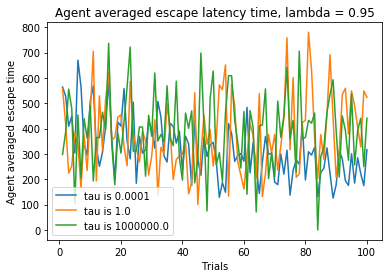

lambda is 0.99
tau is 0.0001
[ 382.3  509.9  535.2  680.6  478.4  461.5  407.4  288.5  384.1  278.2
  391.1  382.1  389.7  381.6  376.2  382.6  320.3  289.3  342.8  209.
  283.1  190.3  239.1  161.4  252.7  211.   171.6  257.3  397.7  356.1
  352.3  227.6  187.8  319.3  275.   168.2  324.3  247.5  224.9  212.5
  205.4   84.5  360.2  179.5  126.8  208.9  181.8  296.2   68.2  348.7
  195.2  161.5  390.1  128.7  174.6  251.6  231.3  219.2  151.2  190.5
  201.4  238.8  128.4  124.9   97.8  174.6  178.6  121.6  138.4  122.1
   91.2  219.5  181.1   94.4  229.1  129.4  130.   229.8  104.1  205.8
  116.1  139.9  172.6  201.3  166.4  275.   115.4  129.9  194.5  305.7
  149.8  109.1  213.6  138.1  171.9  148.6  204.4  110.7   96.2  225.7] (100,) agent averaged esacpe latency times
tau is 1.0
[  594.1   407.7   431.1   263.7   438.8   210.6   204.5     0.    192.8
   408.2   302.7   237.4   154.9   460.2   298.7   354.8   487.    314.7
   309.8   359.8   424.8   326.6   357.5   314.2   608.3   37

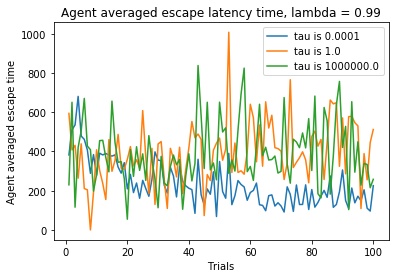

In [127]:
def explore_taus_lambdas():
    taus = [0.0001,1.,1000000.]
    #taus = [0.0001,100000.]
    #lambdas = [0.95]
    lambdas = [0.90,0.95,0.99]

    iters = 100
    for l in lambdas:
        print("lambda is {}".format(l))
        av_times[l] = {}
        plt.figure()
        for tau in taus:
            print("tau is {}".format(tau))
            av_times[l][tau] = get_escape_rate(t=tau,lam=l,its=iters,plot_field=False)
        plt.plot(np.linspace(1,iters,iters),av_times[l][taus[0]],label="tau is {}".format(taus[0]))
        plt.plot(np.linspace(1,iters,iters),av_times[l][taus[1]],label="tau is {}".format(taus[1]))
        plt.plot(np.linspace(1,iters,iters),av_times[l][taus[2]],label="tau is {}".format(taus[2]))
        #plt.plot(np.linspace(1,its,its),av_times[l][taus[2]],label="tau is {}".format(taus[2]))
        plt.title("Agent averaged escape latency time, lambda = {}".format(l))
        plt.xlabel("Trials")
        plt.ylabel("Agent averaged escape time")
        plt.legend()
        plt.show()
        
explore_taus_lambdas()

# Escape time vs. trial for different $\eta$

lambda is 0.95
eta is 1e-05
[  53.1  655.1  345.8  608.9  138.3  377.5  685.5  538.9  562.2  465.3
  438.1  205.2  496.3  483.9  262.8  443.4  256.7  462.8  223.1  836.1
  406.5  428.5  445.5  451.4  468.6  402.   418.9  694.7  514.2  380.3
  232.8  500.4  497.   251.   522.5  381.2  557.7  312.2  573.2  572.
  400.8  311.1  394.   653.3  754.9  566.5  553.8  518.1  201.5  448.7
  634.4  369.1  401.   592.2  599.6  925.5  509.6  661.4  649.7  380.8
  529.4  238.7  631.6  467.6  452.4  471.7  305.1  526.5  509.8  304.4
  469.1  483.4  418.   388.8  389.3  451.   499.3  385.3  307.9  404.1
  319.1  468.5  312.3  438.3  412.2  442.2  583.5  463.5  466.1  472.8
  755.8  393.1  477.3  345.6  450.6  558.9  458.9  457.8  589.8  311.9] (100,) agent averaged esacpe latency times
eta is 2e-05
[ 536.9  464.4  420.3  249.8  238.6  557.6  603.1  472.7  386.4  435.3
  620.5  415.8  582.2  470.7  715.2  166.2  742.3  615.9  438.3  507.6
  434.8  568.2  490.9  355.9  284.9  727.7  376.4  798.7  296.6 

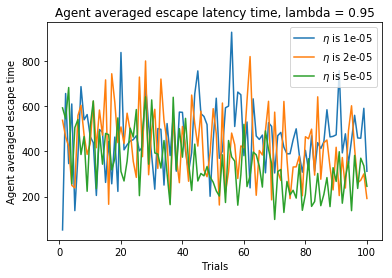

In [104]:
times_opt = {}
def optimise_eta():
    tau = 0.0001 #For one value of tau and lambda
    lambdas = [0.95]
    #ets = [0.0001,0.0002,0.0005] #For 0.001 probs don't add to one!!
    ets = [0.00001,0.00002,0.00005]

    iters = 100
    for l in lambdas:
        print("lambda is {}".format(l))
        times_opt[l] = {}
        plt.figure()
        for e in ets:
            print("eta is {}".format(e))
            times_opt[l][e] = get_escape_rate(t=tau,et=e,lam=l,its=iters,plot_field=False)
        plt.plot(np.linspace(1,iters,iters),times_opt[l][ets[0]],label=r'$\eta$ is {}'.format(ets[0]))
        plt.plot(np.linspace(1,iters,iters),times_opt[l][ets[1]],label=r'$\eta$ is {}'.format(ets[1]))
        plt.plot(np.linspace(1,iters,iters),times_opt[l][ets[2]],label=r'$\eta$ is {}'.format(ets[2]))
        plt.title("Agent averaged escape latency time, lambda = {}".format(l))
        plt.xlabel("Trials")
        plt.ylabel("Agent averaged escape time")
        plt.legend()
        plt.show()
        
optimise_eta()

lambda is 0.1
eta is 1e-05
[ 497.1  452.2  251.3  423.   136.3  391.4  195.   332.6  199.1  376.4
  270.9  548.   432.3  620.2  493.3  241.7  438.8  352.8  349.5  303.3
  109.6  296.5  269.5  601.4  277.8  619.3  438.1  328.6  471.7  358.5
  226.4  632.8  403.   214.7  400.4  304.5  375.   318.7  387.   302.7
  601.2  556.2  143.   464.5   78.4  738.5  480.5  685.5  231.9  798. ] (50,) agent averaged esacpe latency times
eta is 5e-05
[ 478.   355.4  178.5  443.9  274.7  489.8  499.1  334.4  253.3    0.
  483.3  364.9  530.4  577.3  420.2  419.   385.3  340.    49.1  221.8
  568.5  348.9  252.2  411.8  813.   161.1  144.3  118.2  557.1  580.6
  231.1  250.8  238.1  495.6  587.6  334.6  751.8  220.3  571.9  551.4
  325.2  139.5  523.6  452.5  229.1  256.8  519.7  423.2  529.   280.9] (50,) agent averaged esacpe latency times
eta is 0.0001
[ 416.7  331.2  515.4  627.1  364.2  423.9  423.9  314.7  602.1  347.1
  541.   416.6  516.9  139.2  175.3  354.5  574.8  222.6  544.2  155.9
  357.4  

/Users/arvingopal5794/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/arvingopal5794/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/Users/arvingopal5794/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/Users/arvingopal5794/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in less


Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
[ 571.3  375.4  369.8  651.1  371.   327.4  274.   255.9  224.9  362.
  295.8  400.7  235.3  429.7  320.7  339.5  194.9  238.5  201.   254.4
  284.1  182.4  391.4  219.6  291.4  288.4  196.2  273.1  100.5  208.1
  347.3  362.    90.1  266.   262.   311.2   77.7  266.1  211.7  184.5
  357.1  128.9  149.3  177.

Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
[ 274.2  412.1  383.3  301.9  536.1  185.5  340.2  307.9  172.1  494.3
  382.3  215.5  355.2  142.6  318.2  274.1  166.   410.9  414.7  237.8
  176.8  169.7  263.4  341.1  214.3  285.5  347.5  249.3  137.8  317.5
  223.6  229.   265.6  160.7  229.7  290.6  170.7  332.9  105.7  202.
  152.3  229.9  134.7  229.1  144.9  312.4  188.5  334.   367.7  197.4] (50,) agent averaged esacpe latency times
eta is 0.0005
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're:

Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They'

Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They'

Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They'

Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
Probability does not sum up! They're: [  0.  nan   0.], with sum nan
[ 339.3  645.3  156.7  311.1  775.2  356.8  374.4  454.4  366.5  241.6
  194.7  180.5  208.9  271.3  270.3  227.2  241.6  257.1  236.5  431.6
  169.6  372.5  213.3  193.5  246.6  294.7  188.8  252.1  268.8  270.1
  246.2  115.   188.3  218.5  214.   154.6  284.9  186.7  198.5  185.7
  265.7  197.4  206.6  220.   276.   200.4  204.6  149.3  194.7  246.7] (50,) agent averaged esacpe latency times
eta is 0.0005
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're

Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They'

Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They'

Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They'

Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They'

Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They'

Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They'

Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They'

Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They'

Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They'

Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They'

Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They're: [  0.   0.  nan], with sum nan
Probability does not sum up! They'

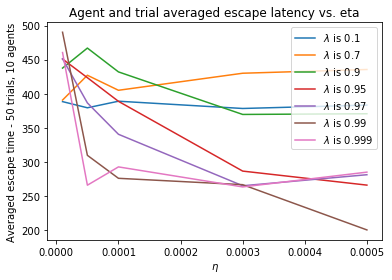

In [128]:

def optimise_eta_trialaveraged(lambdas,etas,iters=50,tau=0.0001):
    """Plots trail and agent averaged escape times vs. eta for different lambdas"""
    times_opt_av = {}
    for l in lambdas:
        print("lambda is {}".format(l))
        times_opt_av[l] = []
        plt.figure()
        for e in ets:
            print("eta is {}".format(e))
            times = get_escape_rate(t=tau,et=e,lam=l,its=iters,plot_field=False)
            times_opt_av[l].append(np.mean(times))
    
    return times_opt_av       
        
#ets = [0.00001,0.00002,0.00005,0.0001,0.0002,0.0005,0.0003]
#lambdas = [0.1,0.3,0.5,0.7,0.9,0.999]
#iters=100
ets = [0.00001,0.00005,0.0001,0.0003,0.0005]
lambdas = [0.1,0.7,0.90,0.95,0.97,0.99,0.999]
its = 50
times_opt_av = optimise_eta_trialaveraged(lambdas,ets,iters=its)

plt.figure()
plt.plot(ets,times_opt_av[lambdas[0]],label=r'$\lambda$ is {}'.format(lambdas[0]))
plt.plot(ets,times_opt_av[lambdas[1]],label=r'$\lambda$ is {}'.format(lambdas[1]))
plt.plot(ets,times_opt_av[lambdas[2]],label=r'$\lambda$ is {}'.format(lambdas[2]))
plt.plot(ets,times_opt_av[lambdas[3]],label=r'$\lambda$ is {}'.format(lambdas[3]))
plt.plot(ets,times_opt_av[lambdas[4]],label=r'$\lambda$ is {}'.format(lambdas[4]))
plt.plot(ets,times_opt_av[lambdas[5]],label=r'$\lambda$ is {}'.format(lambdas[5]))
plt.plot(ets,times_opt_av[lambdas[6]],label=r'$\lambda$ is {}'.format(lambdas[6]))
plt.title("Agent and trial averaged escape latency vs. eta")
plt.xlabel(r'$\eta$')
plt.ylabel("Averaged escape time - 50 trials, 10 agents")
plt.legend()
plt.show()

t = 0.0
t = 1.0
t = 2.0
t = 3.0
t = 4.0
t = 5.0
t = 6.0
t = 7.0
t = 8.0
t = 9.0
t = 10.0
t = 11.0
t = 12.0
t = 13.0
t = 14.0
t = 15.0
t = 16.0
t = 17.0
t = 18.0
t = 19.0
t = 20.0
t = 21.0
t = 22.0
t = 23.0
t = 24.0
t = 25.0
t = 26.0
t = 27.0
t = 28.0
t = 29.0
t = 30.0
t = 31.0
t = 32.0
t = 33.0
t = 34.0
t = 35.0
t = 36.0
t = 37.0
t = 38.0
t = 39.0
t = 40.0
t = 41.0
t = 42.0
t = 43.0
t = 44.0
t = 45.0
t = 46.0
t = 47.0
t = 48.0
t = 49.0
t = 50.0
t = 51.0
t = 52.0
t = 53.0
t = 54.0
t = 55.0
t = 56.0
t = 57.0
t = 58.0
t = 59.0
t = 60.0
t = 61.0
t = 62.0
t = 63.0
t = 64.0
t = 65.0
t = 66.0
t = 67.0
t = 68.0
t = 69.0
t = 70.0
t = 71.0
t = 72.0
t = 73.0
t = 74.0
t = 75.0
t = 76.0
t = 77.0
t = 78.0
t = 79.0
t = 80.0
t = 81.0
t = 82.0
t = 83.0
t = 84.0
t = 85.0
t = 86.0
t = 87.0
t = 88.0
t = 89.0
t = 90.0
t = 91.0
t = 92.0
t = 93.0
t = 94.0
t = 95.0
t = 96.0
t = 97.0
t = 98.0
t = 99.0
t = 100.0
t = 101.0
t = 102.0
t = 103.0
t = 104.0
t = 105.0
t = 106.0
t = 107.0
t = 108.0
t = 109.0
t = 110.0


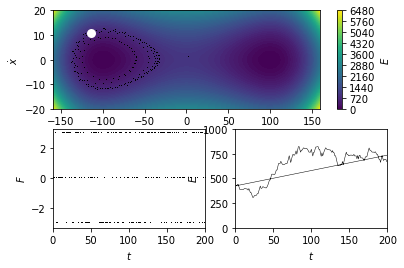

In [14]:
d.visualize_trial()